In [1]:
#initial stetup

import sys
sys.path.append(r'Desktop\SMU_files\\')
import Keithley2401_voltmeter_063023 as K2401
import pyvisa
import time
import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

rm = pyvisa.ResourceManager()
SMU_RM = rm.open_resource('GPIB0::3::INSTR')
SMU = K2401.Keithley2401(SMU_RM)
SMU.initial_setup()
plt.ion()

<IPython.core.display.Javascript object>


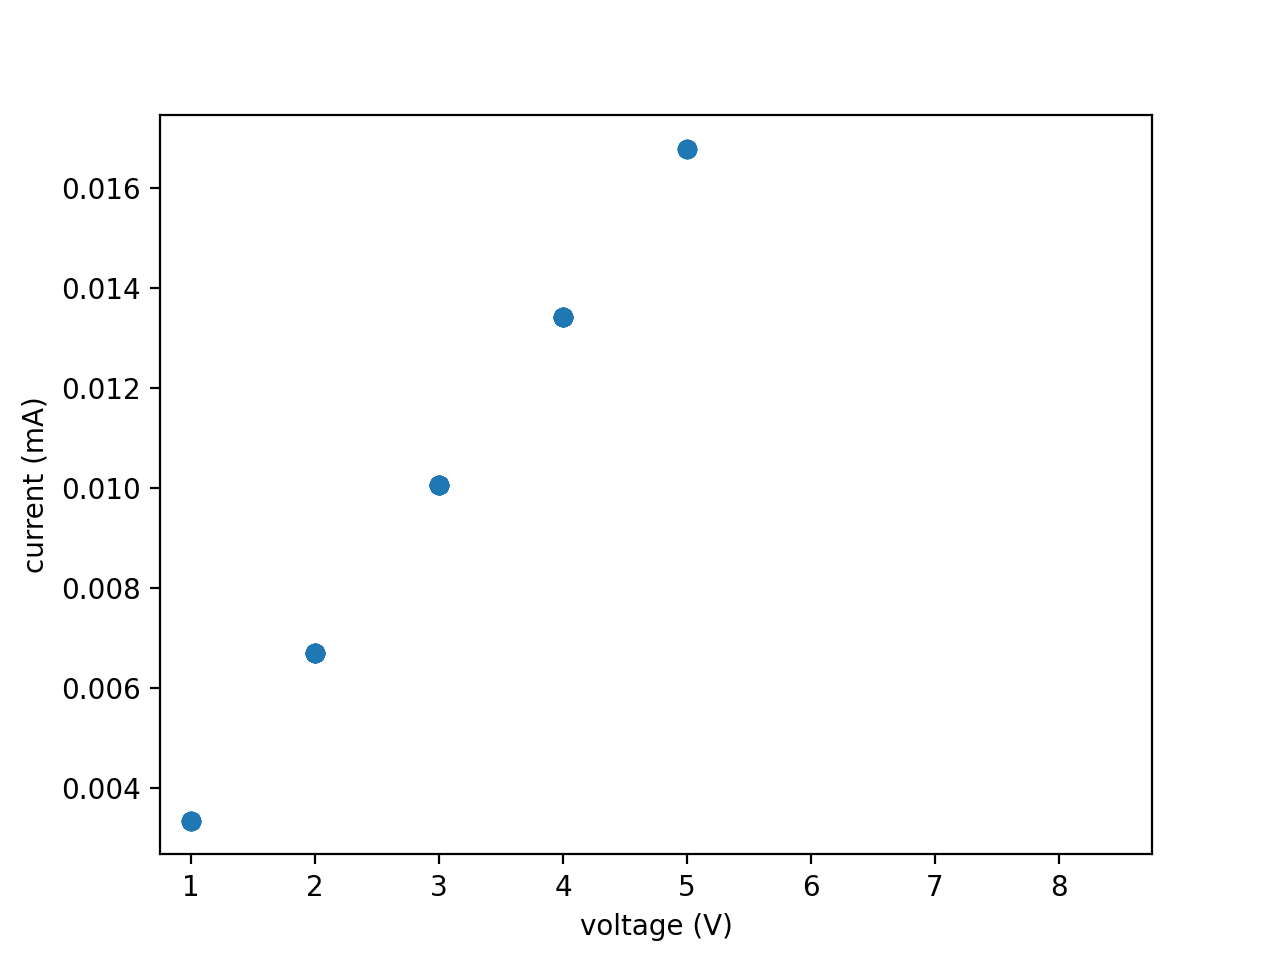

In [2]:
initial_voltage = 1 #sets initial voltage (V)
final_voltage = 5 #sets final voltage (V)
scan_rate = 1 #sets a scan rate (V/s)
cycles = 3 #sets number of cycles

#generates list of voltage values based on range and scan rate
v = K2401.vlist()
v_range = v.generate(initial_voltage = initial_voltage, final_voltage = final_voltage, scan_rate = scan_rate, cycles = cycles)

NPLC = 1
V_range = 20 # voltage range
V_compliance = 11 # max voltage
I_compliance = 1e-1 # max current
voltage_level = initial_voltage #sets constant voltage initially
init_wait = 0.25 # does not do anything yet
SMU.setup_single_Imeas(NPLC = NPLC, V_range = V_range, V_compliance = V_compliance, I_compliance = I_compliance, voltage_level = voltage_level, init_wait = init_wait)
SMU.turn_on()

#initializes dynamically updating plot and creates lists to store data
vc = K2401.DynamicUpdateCV()

vc.on_launch("voltage (V)", "current (mA)", initial_voltage * 0.75, final_voltage * 1.75)

voltages = []
currents = []
times = []

time0 = time.time()

#iterates through list of voltage values and generates data
for voltage in v_range:
            
    time_1 = time.time()
        
    SMU.write(":SOUR:VOLT:LEV {}".format(voltage))
    I, V = SMU.single_Imeas()
    currents.append(I)
    voltages.append(V)
    vc.on_running(voltages, currents)
    
    time_2 = time.time()
    time_error_1 = time_2 - time_1
            
    if time_error_1 < 0.5:
        time.sleep(0.5 - time_error_1)
    else:
        time.sleep(time_error_1)
            
    I, V = SMU.single_Imeas()
    currents.append(I)
    voltages.append(V)
    vc.on_running(voltages, currents)
                    
    time_3 = time.time()
    time_error_2 = time_3 - time_2
            
    if time_error_2 < 0.5:
        time.sleep(0.5 - time_error_2)
    else:
        time.sleep(time_error_2)
                
    times.append(time.time() - time0)
        
    
SMU.turn_off()

#stores data and prints a figure displaying current vs. voltage
vc.on_completion('cyclic_voltammogram', F'{initial_voltage}-{final_voltage}_v', F'{scan_rate}_v_per_s', voltages, currents)